# Bangla FAQ Bot - Colab Notebook Version

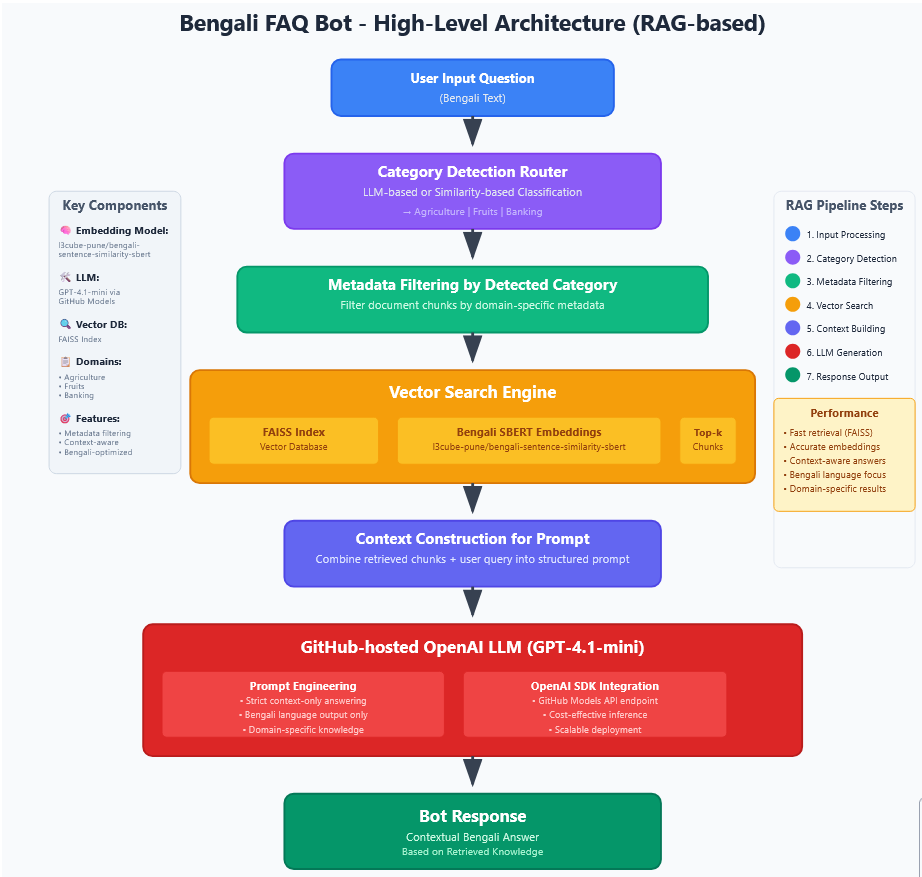

In [ ]:
# --- 1. Install Required Libraries ---
!pip install -qU langchain sentence-transformers transformers faiss-cpu langchain-community
!pip install -qU openai

In [ ]:
## Graudrails (INPUT)-> Reject -> Reject Reason (OUTPUT)

In [ ]:
# !pip install pypdf

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 305.5/305.5 kB 19.1 MB/s eta 0:00:00


In [ ]:
# from langchain_community.document_loaders import PyPDFLoader

# file_path = "/content/Tahmid_Rahman_Cv-2.pdf"
# loader = PyPDFLoader(file_path)

In [ ]:
# docs = loader.load()
# docs[0]

Document(metadata={'producer': 'LuaTeX-1.16.0', 'creator': 'LaTeX with hyperref', 'creationdate': '2025-07-05T18:57:09+00:00', 'author': '', 'keywords': '', 'moddate': '2025-07-05T18:57:09+00:00', 'ptex.fullbanner': 'This is LuaHBTeX, Version 1.16.0 (TeX Live 2023)', 'subject': '', 'title': '', 'trapped': '/False', 'source': '/content/Tahmid_Rahman_Cv-2.pdf', 'total_pages': 1, 'page': 0, 'page_label': '1'}, page_content="T ahmidRahman\n� t ahmidrahman@iut-dhaka.edu | � LinkedIn | � GitHub | � Codeforces\n� Portfolio\nCAREER OBJECTIVES\n• Solve complex problems and drive innovation with data and AI.\n• Build scalable, production-ready AI solutions for real-world impact.\n• Leverage LLMs to create intelligent conversational agents and language solutions.\n• Optimize and deploy high-performance machine learning models.\n• Deliver results under pressure while fostering teamwork and collaboration.\n• Stay ahead with continuous learning in AI and data trends.\nEDUCATION\n� ISLAMIC UNIVERSITY

In [ ]:
# --- 2. Import Required Modules ---
import os
import faiss
import numpy as np
from langchain.vectorstores import FAISS
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.schema import Document
from openai import OpenAI



In [ ]:
# --- 3. Setup Embeddings ---
embedding_model = HuggingFaceEmbeddings(model_name="l3cube-pune/bengali-sentence-similarity-sbert")

/tmp/ipython-input-10-2723695470.py:2: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embedding_model = HuggingFaceEmbeddings(model_name="l3cube-pune/bengali-sentence-similarity-sbert")
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access pu

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/678 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/950M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/527 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/950M [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

# Lets compare with Other Embedding model like allmililm

In [ ]:
# --- 4. Prepare Chunks with Metadata ---
agriculture_chunks = [
    ("ধানের চাষের জন্য ভালো বীজ নির্বাচন করা জরুরি।", {"category": "agriculture"}),
    ("ফসলের জন্য সঠিক সেচ পদ্ধতি ব্যবহার করা উচিত।", {"category": "agriculture"}),
    ("জৈব সার ব্যবহারে মাটির গুণমান ভালো থাকে।", {"category": "agriculture"}),
    ("গম চাষের জন্য ঠাণ্ডা আবহাওয়া উপযোগী।", {"category": "agriculture"}),
    ("পোকামাকড় নিয়ন্ত্রণে বায়োলজিক্যাল পদ্ধতি ব্যবহার করুন।", {"category": "agriculture"}),
    ("ফসল ঘরের পরে জমি বিশ্রাম দেওয়া গুরুত্বপূর্ণ।", {"category": "agriculture"}),
    ("আধুনিক প্রযুক্তি ব্যবহারে কৃষির উৎপাদন বাড়ে।", {"category": "agriculture"}),
    ("আবহাওয়ার পূর্বাভাস দেখে চাষাবাদ করা উচিত।", {"category": "agriculture"}),
    ("শাকসবজি চাষে কম পানি প্রয়োজন।", {"category": "agriculture"}),
    ("কৃষিতে ক্ষুদ্রঋণ সহায়তা প্রদান করে সরকার।", {"category": "agriculture"})
]

fruit_chunks = [
    ("আম পাকা হলে এটি হলুদ রঙ ধারণ করে।", {"category": "fruits"}),
    ("কলা একটি পুষ্টিকর ফল।", {"category": "fruits"}),
    ("লিচু গরম আবহাওয়ায় ভালো হয়।", {"category": "fruits"}),
    ("তরমুজ শরীর ঠান্ডা রাখতে সাহায্য করে।", {"category": "fruits"}),
    ("কমলা ভিটামিন সি এর ভালো উৎস।", {"category": "fruits"}),
    ("আনারস হজমে সাহায্য করে।", {"category": "fruits"}),
    ("জাম অনেক অ্যান্টিঅক্সিডেন্ট সমৃদ্ধ।", {"category": "fruits"}),
    ("পেঁপে রক্তচাপ নিয়ন্ত্রণে সাহায্য করে।", {"category": "fruits"}),
    ("ড্রাগন ফল বর্তমানে খুব জনপ্রিয়।", {"category": "fruits"}),
    ("আমরসা রুচি বৃদ্ধি করে।", {"category": "fruits"})
]

bank_chunks = [
    ("ক্রেডিট কার্ড খোলার জন্য জাতীয় পরিচয়পত্র প্রয়োজন।", {"category": "bank"}),
    ("ব্যাংক অ্যাকাউন্ট খোলার জন্য ফরম পূরণ করতে হয়।", {"category": "bank"}),
    ("চেকবই পাওয়ার জন্য অ্যাকাউন্ট অ্যাকটিভ থাকতে হবে।", {"category": "bank"}),
    ("এটিএম কার্ড ব্যবহার করে টাকা তোলা যায়।", {"category": "bank"}),
    ("মোবাইল ব্যাংকিং সার্ভিস বর্তমানে খুব জনপ্রিয়।", {"category": "bank"}),
    ("সঞ্চয়ী অ্যাকাউন্টে সুদের হার কম।", {"category": "bank"}),
    ("ব্যাংক লোন নেওয়ার জন্য জামিনদার লাগতে পারে।", {"category": "bank"}),
    ("ইন্টারনেট ব্যাংকিংয়ের মাধ্যমে ঘরে বসেই লেনদেন করা যায়।", {"category": "bank"}),
    ("ক্রেডিট কার্ডে সীমা নির্ধারণ করা থাকে।", {"category": "bank"}),
    ("অনলাইন ব্যাংকিং সেবার জন্য আলাদা পাসওয়ার্ড লাগে।", {"category": "bank"})
]


In [ ]:
all_chunks = agriculture_chunks + fruit_chunks + bank_chunks

In [ ]:
# --- 5. Create Vector Store with Metadata ---
documents = [Document(page_content=text, metadata=meta) for text, meta in all_chunks]


In [ ]:
len(documents)

30

In [ ]:
vector_store = FAISS.from_documents(documents, embedding_model)

In [ ]:

# cat= Agriculture  list [ 1-> Argiculture , 2-> ... , 3->Agri , ...] -> 1 ,3

In [ ]:
# --- 6. Define Metadata Filter Function ---
def filter_by_metadata(query, category):
    """
    Filter vector store by category metadata first, then perform similarity search.
    """
    print("\n[Metadata Filtering] Category:", category)
    filtered_docs = [doc for doc in documents if doc.metadata['category'] == category]
    for doc in filtered_docs:
        print(" -", doc.page_content)

    if not filtered_docs:
        return []
    temp_vector_store = FAISS.from_documents(filtered_docs, embedding_model)
    similar_docs = temp_vector_store.similarity_search(query, k=2)

    print("\n[Similarity Search Results for Query]", query)
    for doc in similar_docs:
        print(" >>", doc.page_content)

    return similar_docs

In [ ]:
# --- 7. Setup GitHub-hosted OpenAI LLM (via OpenAI SDK) ---
os.environ['GITHUB_TOKEN'] = "Use Your Key Here"  # Replace with actual token
token = os.environ['GITHUB_TOKEN']
endpoint = "https://models.github.ai/inference"
model = "openai/gpt-4.1-nano"

client = OpenAI(
    base_url=endpoint,
    api_key=token,
)

In [ ]:
# --- 8. Define Final RAG Chain ---
def ask_faq_bot(user_question: str, category: str):
    print("\n[User Question]", user_question)
    docs = filter_by_metadata(user_question, category)
    context = "\n".join([doc.page_content for doc in docs])
    response = client.chat.completions.create(
        messages=[
            {
                "role": "system",
                "content": "তুমি একজন সহায়ক বাংলা সহকারী। শুধুমাত্র নিচের প্রাসঙ্গিক তথ্য থেকে উত্তর দাও। যদি প্রশ্নের উত্তর এতে না থাকে, বলো 'দুঃখিত, এই বিষয়ে আমার জানা নেই।" + context,
            },
            {
                "role": "user",
                "content": user_question,
            }
        ],
        temperature=0.7,
        top_p=1.0,
        model=model
    )
    return response.choices[0].message.content

In [ ]:
# --- 9. Test Questions (Each in Different Cell Below) ---

# Cell 1
question = "আমি কীভাবে একটি ক্রেডিট কার্ড খুলতে পারি?"
category = "bank"
response = ask_faq_bot(question, category)
print("উত্তর:", response)


[User Question] আমি কীভাবে একটি ক্রেডিট কার্ড খুলতে পারি?

[Metadata Filtering] Category: bank
 - ক্রেডিট কার্ড খোলার জন্য জাতীয় পরিচয়পত্র প্রয়োজন।
 - ব্যাংক অ্যাকাউন্ট খোলার জন্য ফরম পূরণ করতে হয়।
 - চেকবই পাওয়ার জন্য অ্যাকাউন্ট অ্যাকটিভ থাকতে হবে।
 - এটিএম কার্ড ব্যবহার করে টাকা তোলা যায়।
 - মোবাইল ব্যাংকিং সার্ভিস বর্তমানে খুব জনপ্রিয়।
 - সঞ্চয়ী অ্যাকাউন্টে সুদের হার কম।
 - ব্যাংক লোন নেওয়ার জন্য জামিনদার লাগতে পারে।
 - ইন্টারনেট ব্যাংকিংয়ের মাধ্যমে ঘরে বসেই লেনদেন করা যায়।
 - ক্রেডিট কার্ডে সীমা নির্ধারণ করা থাকে।
 - অনলাইন ব্যাংকিং সেবার জন্য আলাদা পাসওয়ার্ড লাগে।

[Similarity Search Results for Query] আমি কীভাবে একটি ক্রেডিট কার্ড খুলতে পারি?
 >> ক্রেডিট কার্ড খোলার জন্য জাতীয় পরিচয়পত্র প্রয়োজন।
 >> ক্রেডিট কার্ডে সীমা নির্ধারণ করা থাকে।
উত্তর: ক্রেডিট কার্ড খোলার জন্য জাতীয় পরিচয়পত্র প্রয়োজন।


In [ ]:
# Cell 2
question = "ব্যাংক লোন নিতে কী লাগে?"
category = "bank"
response = ask_faq_bot(question, category)
print("উত্তর:", response)


[User Question] ব্যাংক লোন নিতে কী লাগে?

[Metadata Filtering] Category: bank
 - ক্রেডিট কার্ড খোলার জন্য জাতীয় পরিচয়পত্র প্রয়োজন।
 - ব্যাংক অ্যাকাউন্ট খোলার জন্য ফরম পূরণ করতে হয়।
 - চেকবই পাওয়ার জন্য অ্যাকাউন্ট অ্যাকটিভ থাকতে হবে।
 - এটিএম কার্ড ব্যবহার করে টাকা তোলা যায়।
 - মোবাইল ব্যাংকিং সার্ভিস বর্তমানে খুব জনপ্রিয়।
 - সঞ্চয়ী অ্যাকাউন্টে সুদের হার কম।
 - ব্যাংক লোন নেওয়ার জন্য জামিনদার লাগতে পারে।
 - ইন্টারনেট ব্যাংকিংয়ের মাধ্যমে ঘরে বসেই লেনদেন করা যায়।
 - ক্রেডিট কার্ডে সীমা নির্ধারণ করা থাকে।
 - অনলাইন ব্যাংকিং সেবার জন্য আলাদা পাসওয়ার্ড লাগে।

[Similarity Search Results for Query] ব্যাংক লোন নিতে কী লাগে?
 >> ব্যাংক লোন নেওয়ার জন্য জামিনদার লাগতে পারে।
 >> এটিএম কার্ড ব্যবহার করে টাকা তোলা যায়।
উত্তর: ব্যাংক লোন নেওয়ার জন্য জামিনদার লাগতে পারে।


In [ ]:
# Cell 3
question = "কোন সার মাটির জন্য ভালো?"
category = "agriculture"
response = ask_faq_bot(question, category)
print("উত্তর:", response)



[User Question] কোন সার মাটির জন্য ভালো?

[Metadata Filtering] Category: agriculture
 - ধানের চাষের জন্য ভালো বীজ নির্বাচন করা জরুরি।
 - ফসলের জন্য সঠিক সেচ পদ্ধতি ব্যবহার করা উচিত।
 - জৈব সার ব্যবহারে মাটির গুণমান ভালো থাকে।
 - গম চাষের জন্য ঠাণ্ডা আবহাওয়া উপযোগী।
 - পোকামাকড় নিয়ন্ত্রণে বায়োলজিক্যাল পদ্ধতি ব্যবহার করুন।
 - ফসল ঘরের পরে জমি বিশ্রাম দেওয়া গুরুত্বপূর্ণ।
 - আধুনিক প্রযুক্তি ব্যবহারে কৃষির উৎপাদন বাড়ে।
 - আবহাওয়ার পূর্বাভাস দেখে চাষাবাদ করা উচিত।
 - শাকসবজি চাষে কম পানি প্রয়োজন।
 - কৃষিতে ক্ষুদ্রঋণ সহায়তা প্রদান করে সরকার।

[Similarity Search Results for Query] কোন সার মাটির জন্য ভালো?
 >> জৈব সার ব্যবহারে মাটির গুণমান ভালো থাকে।
 >> ফসল ঘরের পরে জমি বিশ্রাম দেওয়া গুরুত্বপূর্ণ।
উত্তর: জৈব সার মাটির জন্য ভালো।


In [ ]:
# Cell 4
question = "আম পাকা কি ভাবে বুঝব?"
category = "fruits"
response = ask_faq_bot(question, category)
print("উত্তর:", response)


[User Question] আম পাকা কি ভাবে বুঝব?

[Metadata Filtering] Category: fruits
 - আম পাকা হলে এটি হলুদ রঙ ধারণ করে।
 - কলা একটি পুষ্টিকর ফল।
 - লিচু গরম আবহাওয়ায় ভালো হয়।
 - তরমুজ শরীর ঠান্ডা রাখতে সাহায্য করে।
 - কমলা ভিটামিন সি এর ভালো উৎস।
 - আনারস হজমে সাহায্য করে।
 - জাম অনেক অ্যান্টিঅক্সিডেন্ট সমৃদ্ধ।
 - পেঁপে রক্তচাপ নিয়ন্ত্রণে সাহায্য করে।
 - ড্রাগন ফল বর্তমানে খুব জনপ্রিয়।
 - আমরসা রুচি বৃদ্ধি করে।

[Similarity Search Results for Query] আম পাকা কি ভাবে বুঝব?
 >> আম পাকা হলে এটি হলুদ রঙ ধারণ করে।
 >> জাম অনেক অ্যান্টিঅক্সিডেন্ট সমৃদ্ধ।
উত্তর: আম পাকা হলে এটি হলুদ রঙ ধারণ করে।


In [ ]:
# Cell 5
question = "ফসলের উৎপাদন কীভাবে বাড়ানো যায়?"
category = "agriculture"
response = ask_faq_bot(question, category)
print("উত্তর:", response)



[User Question] ফসলের উৎপাদন কীভাবে বাড়ানো যায়?

[Metadata Filtering] Category: agriculture
 - ধানের চাষের জন্য ভালো বীজ নির্বাচন করা জরুরি।
 - ফসলের জন্য সঠিক সেচ পদ্ধতি ব্যবহার করা উচিত।
 - জৈব সার ব্যবহারে মাটির গুণমান ভালো থাকে।
 - গম চাষের জন্য ঠাণ্ডা আবহাওয়া উপযোগী।
 - পোকামাকড় নিয়ন্ত্রণে বায়োলজিক্যাল পদ্ধতি ব্যবহার করুন।
 - ফসল ঘরের পরে জমি বিশ্রাম দেওয়া গুরুত্বপূর্ণ।
 - আধুনিক প্রযুক্তি ব্যবহারে কৃষির উৎপাদন বাড়ে।
 - আবহাওয়ার পূর্বাভাস দেখে চাষাবাদ করা উচিত।
 - শাকসবজি চাষে কম পানি প্রয়োজন।
 - কৃষিতে ক্ষুদ্রঋণ সহায়তা প্রদান করে সরকার।

[Similarity Search Results for Query] ফসলের উৎপাদন কীভাবে বাড়ানো যায়?
 >> আধুনিক প্রযুক্তি ব্যবহারে কৃষির উৎপাদন বাড়ে।
 >> ধানের চাষের জন্য ভালো বীজ নির্বাচন করা জরুরি।
উত্তর: অধুনিক প্রযুক্তি ব্যবহারে ফসলের উৎপাদন বাড়ানো যায়।


In [ ]:
# Cell 6
question = "পেঁপে খেলে কী উপকার হয়?"
category = "fruits"
response = ask_faq_bot(question, category)
print("উত্তর:", response)



[User Question] পেঁপে খেলে কী উপকার হয়?

[Metadata Filtering] Category: fruits
 - আম পাকা হলে এটি হলুদ রঙ ধারণ করে।
 - কলা একটি পুষ্টিকর ফল।
 - লিচু গরম আবহাওয়ায় ভালো হয়।
 - তরমুজ শরীর ঠান্ডা রাখতে সাহায্য করে।
 - কমলা ভিটামিন সি এর ভালো উৎস।
 - আনারস হজমে সাহায্য করে।
 - জাম অনেক অ্যান্টিঅক্সিডেন্ট সমৃদ্ধ।
 - পেঁপে রক্তচাপ নিয়ন্ত্রণে সাহায্য করে।
 - ড্রাগন ফল বর্তমানে খুব জনপ্রিয়।
 - আমরসা রুচি বৃদ্ধি করে।

[Similarity Search Results for Query] পেঁপে খেলে কী উপকার হয়?
 >> পেঁপে রক্তচাপ নিয়ন্ত্রণে সাহায্য করে।
 >> আম পাকা হলে এটি হলুদ রঙ ধারণ করে।
উত্তর: পেঁপে খেলে রক্তচাপ নিয়ন্ত্রণে সাহায্য করে।


In [ ]:
question = "আম পাকা কি ভাবে বুঝব?"
category = "fruits"
response = ask_faq_bot(question, category)
print("উত্তর:", response)


[User Question] আম পাকা কি ভাবে বুঝব?

[Metadata Filtering] Category: fruits
 - আম পাকা হলে এটি হলুদ রঙ ধারণ করে।
 - কলা একটি পুষ্টিকর ফল।
 - লিচু গরম আবহাওয়ায় ভালো হয়।
 - তরমুজ শরীর ঠান্ডা রাখতে সাহায্য করে।
 - কমলা ভিটামিন সি এর ভালো উৎস।
 - আনারস হজমে সাহায্য করে।
 - জাম অনেক অ্যান্টিঅক্সিডেন্ট সমৃদ্ধ।
 - পেঁপে রক্তচাপ নিয়ন্ত্রণে সাহায্য করে।
 - ড্রাগন ফল বর্তমানে খুব জনপ্রিয়।
 - আমরসা রুচি বৃদ্ধি করে।

[Similarity Search Results for Query] আম পাকা কি ভাবে বুঝব?
 >> আম পাকা হলে এটি হলুদ রঙ ধারণ করে।
 >> জাম অনেক অ্যান্টিঅক্সিডেন্ট সমৃদ্ধ।
উত্তর: আম পাকা হলে এটি হলুদ রঙ ধারণ করে।


In [ ]:
question = "আজকের আবহাওয়া কেমন হবে?"
category = "bank"  # Intentional mismatch to test out-of-scope question
response = ask_faq_bot(question, category)
print("উত্তর:", response)


[User Question] আজকের আবহাওয়া কেমন হবে?

[Metadata Filtering] Category: bank
 - ক্রেডিট কার্ড খোলার জন্য জাতীয় পরিচয়পত্র প্রয়োজন।
 - ব্যাংক অ্যাকাউন্ট খোলার জন্য ফরম পূরণ করতে হয়।
 - চেকবই পাওয়ার জন্য অ্যাকাউন্ট অ্যাকটিভ থাকতে হবে।
 - এটিএম কার্ড ব্যবহার করে টাকা তোলা যায়।
 - মোবাইল ব্যাংকিং সার্ভিস বর্তমানে খুব জনপ্রিয়।
 - সঞ্চয়ী অ্যাকাউন্টে সুদের হার কম।
 - ব্যাংক লোন নেওয়ার জন্য জামিনদার লাগতে পারে।
 - ইন্টারনেট ব্যাংকিংয়ের মাধ্যমে ঘরে বসেই লেনদেন করা যায়।
 - ক্রেডিট কার্ডে সীমা নির্ধারণ করা থাকে।
 - অনলাইন ব্যাংকিং সেবার জন্য আলাদা পাসওয়ার্ড লাগে।

[Similarity Search Results for Query] আজকের আবহাওয়া কেমন হবে?
 >> ক্রেডিট কার্ডে সীমা নির্ধারণ করা থাকে।
 >> চেকবই পাওয়ার জন্য অ্যাকাউন্ট অ্যাকটিভ থাকতে হবে।
উত্তর: দুঃখিত, এই বিষয়ে আমার জানা নেই।


In [ ]:
question = "চাঁদে কতবার মানুষ গিয়েছে?"
category = "agriculture"
response = ask_faq_bot(question, category)
print("উত্তর:", response)


[User Question] চাঁদে কতবার মানুষ গিয়েছে?

[Metadata Filtering] Category: agriculture
 - ধানের চাষের জন্য ভালো বীজ নির্বাচন করা জরুরি।
 - ফসলের জন্য সঠিক সেচ পদ্ধতি ব্যবহার করা উচিত।
 - জৈব সার ব্যবহারে মাটির গুণমান ভালো থাকে।
 - গম চাষের জন্য ঠাণ্ডা আবহাওয়া উপযোগী।
 - পোকামাকড় নিয়ন্ত্রণে বায়োলজিক্যাল পদ্ধতি ব্যবহার করুন।
 - ফসল ঘরের পরে জমি বিশ্রাম দেওয়া গুরুত্বপূর্ণ।
 - আধুনিক প্রযুক্তি ব্যবহারে কৃষির উৎপাদন বাড়ে।
 - আবহাওয়ার পূর্বাভাস দেখে চাষাবাদ করা উচিত।
 - শাকসবজি চাষে কম পানি প্রয়োজন।
 - কৃষিতে ক্ষুদ্রঋণ সহায়তা প্রদান করে সরকার।

[Similarity Search Results for Query] চাঁদে কতবার মানুষ গিয়েছে?
 >> আধুনিক প্রযুক্তি ব্যবহারে কৃষির উৎপাদন বাড়ে।
 >> আবহাওয়ার পূর্বাভাস দেখে চাষাবাদ করা উচিত।
উত্তর: দুঃখিত, এই বিষয়ে আমার জানা নেই।


In [ ]:
question = "বাংলাদেশের জাতীয় সংগীত কে লিখেছেন?"
category = "bank"
response = ask_faq_bot(question, category)
print("উত্তর:", response)


[User Question] বাংলাদেশের জাতীয় সংগীত কে লিখেছেন?

[Metadata Filtering] Category: bank
 - ক্রেডিট কার্ড খোলার জন্য জাতীয় পরিচয়পত্র প্রয়োজন।
 - ব্যাংক অ্যাকাউন্ট খোলার জন্য ফরম পূরণ করতে হয়।
 - চেকবই পাওয়ার জন্য অ্যাকাউন্ট অ্যাকটিভ থাকতে হবে।
 - এটিএম কার্ড ব্যবহার করে টাকা তোলা যায়।
 - মোবাইল ব্যাংকিং সার্ভিস বর্তমানে খুব জনপ্রিয়।
 - সঞ্চয়ী অ্যাকাউন্টে সুদের হার কম।
 - ব্যাংক লোন নেওয়ার জন্য জামিনদার লাগতে পারে।
 - ইন্টারনেট ব্যাংকিংয়ের মাধ্যমে ঘরে বসেই লেনদেন করা যায়।
 - ক্রেডিট কার্ডে সীমা নির্ধারণ করা থাকে।
 - অনলাইন ব্যাংকিং সেবার জন্য আলাদা পাসওয়ার্ড লাগে।

[Similarity Search Results for Query] বাংলাদেশের জাতীয় সংগীত কে লিখেছেন?
 >> ক্রেডিট কার্ড খোলার জন্য জাতীয় পরিচয়পত্র প্রয়োজন।
 >> ক্রেডিট কার্ডে সীমা নির্ধারণ করা থাকে।
উত্তর: দুঃখিত, এই বিষয়ে আমার জানা নেই।


In [ ]:
# --- 10. Add Category Router

def detect_category_llm(question):
    """
    Use LLM to determine appropriate category
    """
    system_msg = "তুমি একটি শ্রেণিবিন্যাসকারী এজেন্ট। নিচের প্রশ্নটি পড়ে বলো এটি কোন ক্যাটাগরির মধ্যে পড়ে: agriculture, fruits, bank। শুধুমাত্র ক্যাটাগরির নাম এক শব্দে ইংরেজিতে উত্তর দাও।"
    response = client.chat.completions.create(
        messages=[
            {"role": "system", "content": system_msg},
            {"role": "user", "content": question}
        ],
        model=model,
        temperature=0,
        top_p=1.0
    )
    category = response.choices[0].message.content.strip().lower()
    print("[LLM Router] Category:", category)
    return category

In [ ]:
question = "আমি কীভাবে একটি ক্রেডিট কার্ড খুলতে পারি?"
category = detect_category_llm(question)
response = ask_faq_bot(question, category)
print("উত্তর:", response)


[LLM Router] Category: bank

[User Question] আমি কীভাবে একটি ক্রেডিট কার্ড খুলতে পারি?

[Metadata Filtering] Category: bank
 - ক্রেডিট কার্ড খোলার জন্য জাতীয় পরিচয়পত্র প্রয়োজন।
 - ব্যাংক অ্যাকাউন্ট খোলার জন্য ফরম পূরণ করতে হয়।
 - চেকবই পাওয়ার জন্য অ্যাকাউন্ট অ্যাকটিভ থাকতে হবে।
 - এটিএম কার্ড ব্যবহার করে টাকা তোলা যায়।
 - মোবাইল ব্যাংকিং সার্ভিস বর্তমানে খুব জনপ্রিয়।
 - সঞ্চয়ী অ্যাকাউন্টে সুদের হার কম।
 - ব্যাংক লোন নেওয়ার জন্য জামিনদার লাগতে পারে।
 - ইন্টারনেট ব্যাংকিংয়ের মাধ্যমে ঘরে বসেই লেনদেন করা যায়।
 - ক্রেডিট কার্ডে সীমা নির্ধারণ করা থাকে।
 - অনলাইন ব্যাংকিং সেবার জন্য আলাদা পাসওয়ার্ড লাগে।

[Similarity Search Results for Query] আমি কীভাবে একটি ক্রেডিট কার্ড খুলতে পারি?
 >> ক্রেডিট কার্ড খোলার জন্য জাতীয় পরিচয়পত্র প্রয়োজন।
 >> ক্রেডিট কার্ডে সীমা নির্ধারণ করা থাকে।
উত্তর: ক্রেডিট কার্ড খোলার জন্য জাতীয় পরিচয়পত্র প্রয়োজন।


In [ ]:
question = "ব্যাংক লোন নিতে কী লাগে?"
category = detect_category_llm(question)
response = ask_faq_bot(question, category)
print("উত্তর:", response)


[LLM Router] Category: bank

[User Question] ব্যাংক লোন নিতে কী লাগে?

[Metadata Filtering] Category: bank
 - ক্রেডিট কার্ড খোলার জন্য জাতীয় পরিচয়পত্র প্রয়োজন।
 - ব্যাংক অ্যাকাউন্ট খোলার জন্য ফরম পূরণ করতে হয়।
 - চেকবই পাওয়ার জন্য অ্যাকাউন্ট অ্যাকটিভ থাকতে হবে।
 - এটিএম কার্ড ব্যবহার করে টাকা তোলা যায়।
 - মোবাইল ব্যাংকিং সার্ভিস বর্তমানে খুব জনপ্রিয়।
 - সঞ্চয়ী অ্যাকাউন্টে সুদের হার কম।
 - ব্যাংক লোন নেওয়ার জন্য জামিনদার লাগতে পারে।
 - ইন্টারনেট ব্যাংকিংয়ের মাধ্যমে ঘরে বসেই লেনদেন করা যায়।
 - ক্রেডিট কার্ডে সীমা নির্ধারণ করা থাকে।
 - অনলাইন ব্যাংকিং সেবার জন্য আলাদা পাসওয়ার্ড লাগে।

[Similarity Search Results for Query] ব্যাংক লোন নিতে কী লাগে?
 >> ব্যাংক লোন নেওয়ার জন্য জামিনদার লাগতে পারে।
 >> এটিএম কার্ড ব্যবহার করে টাকা তোলা যায়।
উত্তর: ব্যাংক লোন নেওয়ার জন্য জামিনদার লাগতে পারে।


In [ ]:
question = "আম পাকা কি ভাবে বুঝব?"
category = detect_category_llm(question)
response = ask_faq_bot(question, category)
print("উত্তর:", response)

[LLM Router] Category: fruits

[User Question] আম পাকা কি ভাবে বুঝব?

[Metadata Filtering] Category: fruits
 - আম পাকা হলে এটি হলুদ রঙ ধারণ করে।
 - কলা একটি পুষ্টিকর ফল।
 - লিচু গরম আবহাওয়ায় ভালো হয়।
 - তরমুজ শরীর ঠান্ডা রাখতে সাহায্য করে।
 - কমলা ভিটামিন সি এর ভালো উৎস।
 - আনারস হজমে সাহায্য করে।
 - জাম অনেক অ্যান্টিঅক্সিডেন্ট সমৃদ্ধ।
 - পেঁপে রক্তচাপ নিয়ন্ত্রণে সাহায্য করে।
 - ড্রাগন ফল বর্তমানে খুব জনপ্রিয়।
 - আমরসা রুচি বৃদ্ধি করে।

[Similarity Search Results for Query] আম পাকা কি ভাবে বুঝব?
 >> আম পাকা হলে এটি হলুদ রঙ ধারণ করে।
 >> জাম অনেক অ্যান্টিঅক্সিডেন্ট সমৃদ্ধ।
উত্তর: আম পাকা হলে এটি হলুদ রঙ ধারণ করে।


In [ ]:
question = "বাংলাদেশের জাতীয় সংগীত কে লিখেছেন?"
category = detect_category_llm(question)
response = ask_faq_bot(question, category)
print("উত্তর:", response)

[LLM Router] Category: bank

[User Question] বাংলাদেশের জাতীয় সংগীত কে লিখেছেন?

[Metadata Filtering] Category: bank
 - ক্রেডিট কার্ড খোলার জন্য জাতীয় পরিচয়পত্র প্রয়োজন।
 - ব্যাংক অ্যাকাউন্ট খোলার জন্য ফরম পূরণ করতে হয়।
 - চেকবই পাওয়ার জন্য অ্যাকাউন্ট অ্যাকটিভ থাকতে হবে।
 - এটিএম কার্ড ব্যবহার করে টাকা তোলা যায়।
 - মোবাইল ব্যাংকিং সার্ভিস বর্তমানে খুব জনপ্রিয়।
 - সঞ্চয়ী অ্যাকাউন্টে সুদের হার কম।
 - ব্যাংক লোন নেওয়ার জন্য জামিনদার লাগতে পারে।
 - ইন্টারনেট ব্যাংকিংয়ের মাধ্যমে ঘরে বসেই লেনদেন করা যায়।
 - ক্রেডিট কার্ডে সীমা নির্ধারণ করা থাকে।
 - অনলাইন ব্যাংকিং সেবার জন্য আলাদা পাসওয়ার্ড লাগে।

[Similarity Search Results for Query] বাংলাদেশের জাতীয় সংগীত কে লিখেছেন?
 >> ক্রেডিট কার্ড খোলার জন্য জাতীয় পরিচয়পত্র প্রয়োজন।
 >> ক্রেডিট কার্ডে সীমা নির্ধারণ করা থাকে।
উত্তর: দুঃখিত, এই বিষয়ে আমার জানা নেই।


In [ ]:
question = "পেঁপে খেলে কী উপকার হয়?"
category = detect_category_llm(question)
response = ask_faq_bot(question, category)
print("উত্তর:", response)

[LLM Router] Category: fruits

[User Question] পেঁপে খেলে কী উপকার হয়?

[Metadata Filtering] Category: fruits
 - আম পাকা হলে এটি হলুদ রঙ ধারণ করে।
 - কলা একটি পুষ্টিকর ফল।
 - লিচু গরম আবহাওয়ায় ভালো হয়।
 - তরমুজ শরীর ঠান্ডা রাখতে সাহায্য করে।
 - কমলা ভিটামিন সি এর ভালো উৎস।
 - আনারস হজমে সাহায্য করে।
 - জাম অনেক অ্যান্টিঅক্সিডেন্ট সমৃদ্ধ।
 - পেঁপে রক্তচাপ নিয়ন্ত্রণে সাহায্য করে।
 - ড্রাগন ফল বর্তমানে খুব জনপ্রিয়।
 - আমরসা রুচি বৃদ্ধি করে।

[Similarity Search Results for Query] পেঁপে খেলে কী উপকার হয়?
 >> পেঁপে রক্তচাপ নিয়ন্ত্রণে সাহায্য করে।
 >> আম পাকা হলে এটি হলুদ রঙ ধারণ করে।
উত্তর: পেঁপে খেলে রক্তচাপ নিয়ন্ত্রণে সাহায্য হয়।


## 📘 Bengali FAQ Bot - RAG Architecture

### ✅ Objective
We are building a Bengali FAQ Bot that can answer domain-specific questions (Agriculture, Fruits, Banking) using:
- Metadata filtering
- Semantic search using SBERT Bengali Embeddings
- GitHub-hosted OpenAI LLM (gpt-4.1-mini)

### 🔗 Step-by-Step RAG Chain:
1. **Input User Question in Bangla**
2. **Filter relevant domain (metadata)**
3. **Search for top-k similar chunks using FAISS + SBERT**
4. **Pass context to LLM to generate answer in Bangla**

### 🧠 Embedding Model
We use `l3cube-pune/bengali-sentence-similarity-sbert`, which outperforms multilingual MiniLM for Bengali.

### 🛠️ LLM
We call GPT-4.1-mini from GitHub Models via OpenAI SDK.


# Test with other Embedding and see results

In [ ]:
# Lets compare with Other Embedding model like allmililm
from langchain_community.embeddings import HuggingFaceEmbeddings

# Load another embedding model
other_embedding_model = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")

# You can now compare the performance or use this new model
# For example, you can create a new vector store with this model:
# other_vector_store = FAISS.from_documents(documents, other_embedding_model)

In [ ]:
query="পেঁপে খেলে কী উপকার হয়?"
vector_store_other = FAISS.from_documents(documents, other_embedding_model)
similar_docs = vector_store_other.similarity_search(query, k=5)
for doc in similar_docs:
    print(doc.page_content)

আম পাকা হলে এটি হলুদ রঙ ধারণ করে।
ড্রাগন ফল বর্তমানে খুব জনপ্রিয়।
মোবাইল ব্যাংকিং সার্ভিস বর্তমানে খুব জনপ্রিয়।
কলা একটি পুষ্টিকর ফল।
লিচু গরম আবহাওয়ায় ভালো হয়।


In [ ]:
query="পেঁপে খেলে কী উপকার হয়?"
vector_store = FAISS.from_documents(documents, embedding_model)
similar_docs = vector_store.similarity_search(query, k=5)
for doc in similar_docs:
    print(doc.page_content)

পেঁপে রক্তচাপ নিয়ন্ত্রণে সাহায্য করে।
আম পাকা হলে এটি হলুদ রঙ ধারণ করে।
লিচু গরম আবহাওয়ায় ভালো হয়।
কলা একটি পুষ্টিকর ফল।
আনারস হজমে সাহায্য করে।


In [ ]:
question = "আমি কীভাবে একটি ক্রেডিট কার্ড খুলতে পারি?"
vector_store_other = FAISS.from_documents(documents, other_embedding_model)
similar_docs = vector_store_other.similarity_search(question, k=5)
for doc in similar_docs:
    print(doc.page_content)

এটিএম কার্ড ব্যবহার করে টাকা তোলা যায়।
মোবাইল ব্যাংকিং সার্ভিস বর্তমানে খুব জনপ্রিয়।
আধুনিক প্রযুক্তি ব্যবহারে কৃষির উৎপাদন বাড়ে।
আবহাওয়ার পূর্বাভাস দেখে চাষাবাদ করা উচিত।
শাকসবজি চাষে কম পানি প্রয়োজন।


In [ ]:
question = "আমি কীভাবে একটি ক্রেডিট কার্ড খুলতে পারি?"
vector_store = FAISS.from_documents(documents, embedding_model)
similar_docs = vector_store.similarity_search(question, k=5)
for doc in similar_docs:
    print(doc.page_content)

ক্রেডিট কার্ড খোলার জন্য জাতীয় পরিচয়পত্র প্রয়োজন।
ক্রেডিট কার্ডে সীমা নির্ধারণ করা থাকে।
এটিএম কার্ড ব্যবহার করে টাকা তোলা যায়।
চেকবই পাওয়ার জন্য অ্যাকাউন্ট অ্যাকটিভ থাকতে হবে।
ব্যাংক অ্যাকাউন্ট খোলার জন্য ফরম পূরণ করতে হয়।


In [ ]:
1000 chunks -> LLM Dump -> Context Window (X)
1000 chunk -> 200 Metdata Filtering -> 4 chunk -> (500 words )-> LLM Dump -> Context Window (O)
book -> page(100 word) -> summary ->  1000 -> 1 summary